TV-Regularized Sparse-View CT Reconstruction (ASTRA Projector)
==============================================================

This example demonstrates solution of a sparse-view CT reconstruction
problem with isotropic total variation (TV) regularization

  $$\mathrm{argmin}_{\mathbf{x}} \; (1/2) \| \mathbf{y} - A \mathbf{x}
  \|_2^2 + \lambda \| C \mathbf{x} \|_{2,1} \;,$$

where $A$ is the X-ray transform (the CT forward projection operator),
$\mathbf{y}$ is the sinogram, $C$ is a 2D finite difference operator, and
$\mathbf{x}$ is the desired image. This example uses the CT projector
provided by the astra package, while the companion
[example script](ct_tv_admm.rst) uses the projector integrated into
scico.

In [1]:
import numpy as np

from mpl_toolkits.axes_grid1 import make_axes_locatable
from xdesign import Foam, discrete_phantom

import scico.numpy as snp
from scico import functional, linop, loss, metric, plot
from scico.linop.xray.astra import XRayTransform2D
from scico.optimize.admm import ADMM, LinearSubproblemSolver
from scico.util import device_info
plot.config_notebook_plotting()

Create a ground truth image.

In [2]:
N = 512  # phantom size
np.random.seed(1234)
x_gt = discrete_phantom(Foam(size_range=[0.075, 0.0025], gap=1e-3, porosity=1), size=N)
x_gt = snp.array(x_gt)  # convert to jax type

Configure CT projection operator and generate synthetic measurements.

In [3]:
n_projection = 45  # number of projections
angles = np.linspace(0, np.pi, n_projection)  # evenly spaced projection angles
A = XRayTransform2D(x_gt.shape, N, 1.0, angles)  # CT projection operator
y = A @ x_gt  # sinogram

Set up ADMM solver object.

In [4]:
λ = 2e0  # ℓ1 norm regularization parameter
ρ = 5e0  # ADMM penalty parameter
maxiter = 25  # number of ADMM iterations
cg_tol = 1e-4  # CG relative tolerance
cg_maxiter = 25  # maximum CG iterations per ADMM iteration

# The append=0 option makes the results of horizontal and vertical
# finite differences the same shape, which is required for the L21Norm,
# which is used so that g(Cx) corresponds to isotropic TV.
C = linop.FiniteDifference(input_shape=x_gt.shape, append=0)
g = λ * functional.L21Norm()

f = loss.SquaredL2Loss(y=y, A=A)

x0 = snp.clip(A.fbp(y), 0, 1.0)

solver = ADMM(
    f=f,
    g_list=[g],
    C_list=[C],
    rho_list=[ρ],
    x0=x0,
    maxiter=maxiter,
    subproblem_solver=LinearSubproblemSolver(cg_kwargs={"tol": cg_tol, "maxiter": cg_maxiter}),
    itstat_options={"display": True, "period": 5},
)

Run the solver.

In [5]:
print(f"Solving on {device_info()}\n")
solver.solve()
hist = solver.itstat_object.history(transpose=True)
x_reconstruction = snp.clip(solver.x, 0, 1.0)

Solving on GPU (NVIDIA GeForce RTX 2080 Ti)



Iter  Time      Objective  Prml Rsdl  Dual Rsdl  CG It  CG Res   
-----------------------------------------------------------------
   0  8.42e+00  3.414e+03  1.058e+02  8.652e-01     25  4.699e-04


   5  3.68e+01  2.289e+04  4.214e+01  6.803e+01     19  9.963e-05


  10  5.30e+01  2.680e+04  4.083e+01  4.170e+01     13  9.264e-05


  15  6.48e+01  2.726e+04  3.982e+01  3.606e+01     15  7.510e-05


  20  7.29e+01  2.757e+04  4.257e+01  3.484e+01     14  8.129e-05


  24  7.76e+01  2.790e+04  1.267e+01  5.593e+00      0  9.402e-05


Show the recovered image.

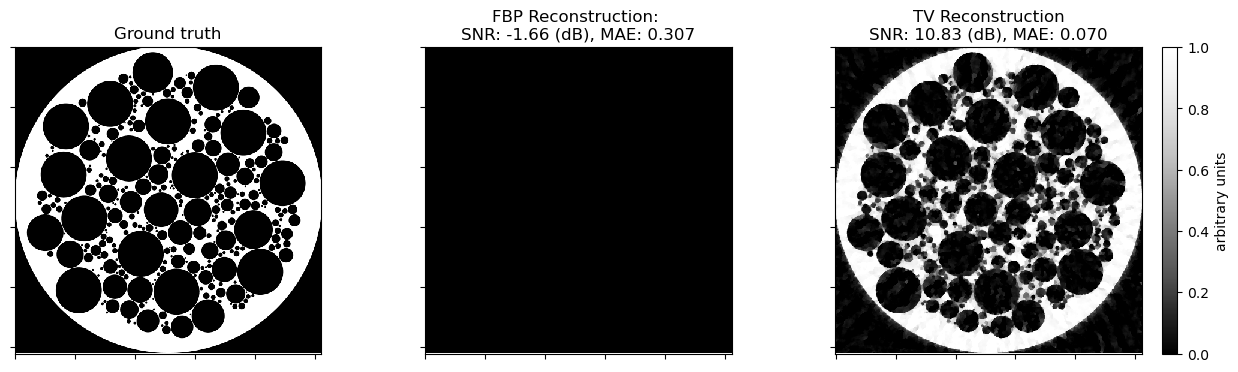

In [6]:
fig, ax = plot.subplots(nrows=1, ncols=3, figsize=(15, 5))
plot.imview(x_gt, title="Ground truth", cbar=None, fig=fig, ax=ax[0])
plot.imview(
    x0,
    title="FBP Reconstruction: \nSNR: %.2f (dB), MAE: %.3f"
    % (metric.snr(x_gt, x0), metric.mae(x_gt, x0)),
    cbar=None,
    fig=fig,
    ax=ax[1],
)
plot.imview(
    x_reconstruction,
    title="TV Reconstruction\nSNR: %.2f (dB), MAE: %.3f"
    % (metric.snr(x_gt, x_reconstruction), metric.mae(x_gt, x_reconstruction)),
    fig=fig,
    ax=ax[2],
)
divider = make_axes_locatable(ax[2])
cax = divider.append_axes("right", size="5%", pad=0.2)
fig.colorbar(ax[2].get_images()[0], cax=cax, label="arbitrary units")
fig.show()

Plot convergence statistics.

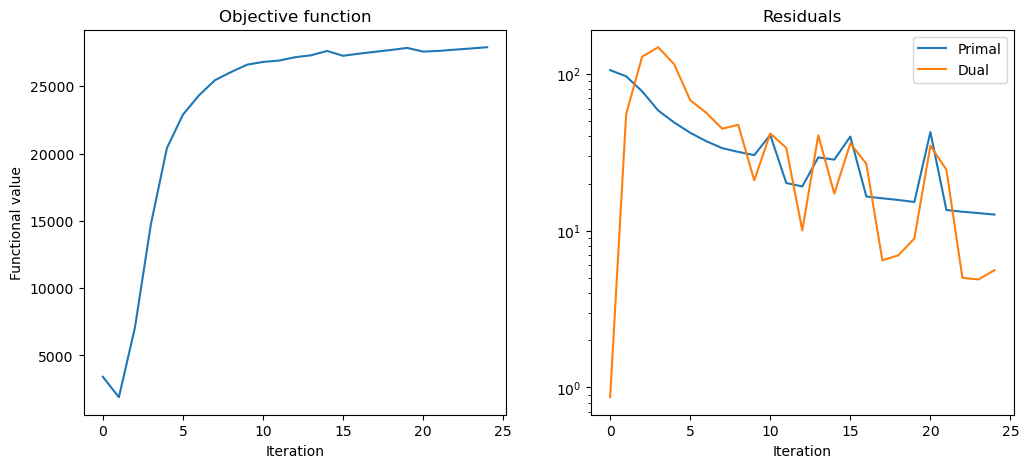

In [7]:
fig, ax = plot.subplots(nrows=1, ncols=2, figsize=(12, 5))
plot.plot(
    hist.Objective,
    title="Objective function",
    xlbl="Iteration",
    ylbl="Functional value",
    fig=fig,
    ax=ax[0],
)
plot.plot(
    snp.vstack((hist.Prml_Rsdl, hist.Dual_Rsdl)).T,
    ptyp="semilogy",
    title="Residuals",
    xlbl="Iteration",
    lgnd=("Primal", "Dual"),
    fig=fig,
    ax=ax[1],
)
fig.show()